# Monet CycleGAN (Final Report)

[LINK TO PROJECT REPO](https://github.com/rpforrest1/Monet_CycleGAN_Project/tree/main)

## Introduction

This project was created as a submission for the _I’m Something of a Painter Myself_ Kaggle competition here: [Kaggle Monet Competition](https://www.kaggle.com/competitions/gan-getting-started). The purpose of the project is to create an model that will transform ordinary pictures into the same image but in Monet's signature style. Its unclear the origin of the original dataset, but it appears to have been created either specifically for this competition or from this repo [here](https://github.com/junyanz/CycleGAN/tree/master) (the monet2photo dataset).

In this project, I intend to build a CycleGAN model that will transform photos into Monet's style images. I'll go through the exploratory data analysis, the model architecture while doing hyperparameter tuning, and the final results.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from PIL import Image
import os

The provided dataset comes with four directories: monet_tfrec, photo_tfrec, monet_jpg, and photo_jpg. The _tfrec and _jpg contain the same pictures, so for this report I will use the _jpg directories.

In [2]:
data_dir = './data'
monet_dir = f'{data_dir}/monet_jpg'
photo_dir = f'{data_dir}/photo_jpg'
monet_files = glob(f'{monet_dir}/*.jpg')
photo_files = glob(f'{photo_dir}/*.jpg')

print('Number of monet files: ', len(monet_files))
print('Number of photo files: ', len(photo_files))

Number of monet files:  300
Number of photo files:  7038


In [3]:
example_image = Image.open(monet_files[0])
image_shape = np.array(example_image).shape
print(f'The monet images are {image_shape[0]} x {image_shape[1]} with {image_shape[2]} color channels.')

example_image = Image.open(photo_files[0])
image_shape = np.array(example_image).shape
print(f'The photo images are {image_shape[0]} x {image_shape[1]} with {image_shape[2]} color channels.')

The monet images are 256 x 256 with 3 color channels.
The photo images are 256 x 256 with 3 color channels.


In [4]:
df = pd.concat([
    pd.DataFrame.from_records(zip(monet_files, range(len(monet_files)))).assign(label='monet'),
    pd.DataFrame.from_records(zip(photo_files, range(len(photo_files)))).assign(label='photo')
])

df.columns = ['file_path', 'id', 'label']

In [5]:
display(df)

file_path    id  label
0     ./data/monet_jpg/1f22663e72.jpg     0  monet
1     ./data/monet_jpg/50855dd324.jpg     1  monet
2     ./data/monet_jpg/66a144f547.jpg     2  monet
3     ./data/monet_jpg/463835bbc6.jpg     3  monet
4     ./data/monet_jpg/2acfbab228.jpg     4  monet
...                               ...   ...    ...
7033  ./data/photo_jpg/baa60c9bed.jpg  7033  photo
7034  ./data/photo_jpg/6fd674c2bc.jpg  7034  photo
7035  ./data/photo_jpg/b635c95844.jpg  7035  photo
7036  ./data/photo_jpg/6e8ec08b46.jpg  7036  photo
7037  ./data/photo_jpg/7e2ad883dd.jpg  7037  photo

[7338 rows x 3 columns]

---

## Exploratory Data Analysis

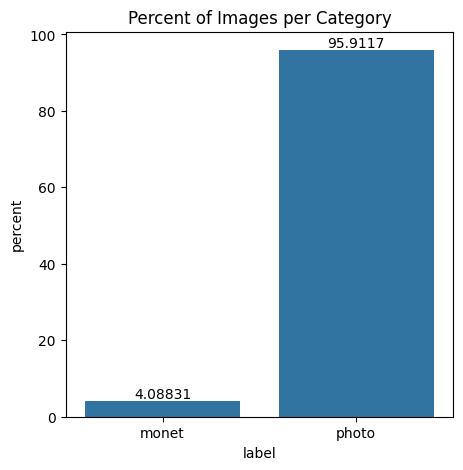

In [6]:
fig, ax = plt.subplots(figsize=(5,5))
_ = sns.countplot(df, x='label', ax=ax, stat='percent')
plt.title('Percent of Images per Category')
plt.bar_label(ax.containers[0])
plt.show()

From the chart above, we can see that there is heavy imbalance in the dataset, with the majority of the labels being regular photos. For the GAN model, I am a little worried that there aren't enough examples of Monet images. I will apply some data augmentation techniques to account for the low amount of data. Since this isn't a classification task, the imbalance issue isn't as severe as it would be under those circumstances.

In [7]:
def plot_examples(label:str, num_examples=8):
    """
    Plots example images.

    Args:
        label: Will be either 'monet' or 'photo'
        num_examples: The number of examples to plot
    """
    example_set = df[df['label'] == label]
    plt.figure(figsize=(num_examples+1, num_examples+1))
    for i in range(num_examples):
        ax = plt.subplot(int(num_examples/2), int(num_examples/2), i + 1)
        plt.imshow(Image.open(example_set.iloc[i]['file_path']))
        plt.subplots_adjust(wspace=0.05, hspace=0.05)
        plt.axis("off")

Example of Monet images.


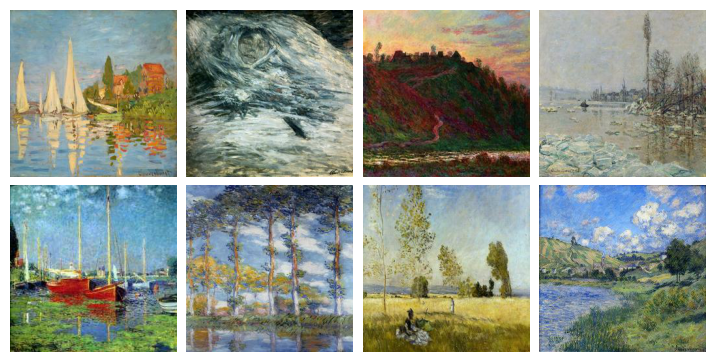

In [8]:
print('Example of Monet images.')
plot_examples('monet')

Example of regular photos.


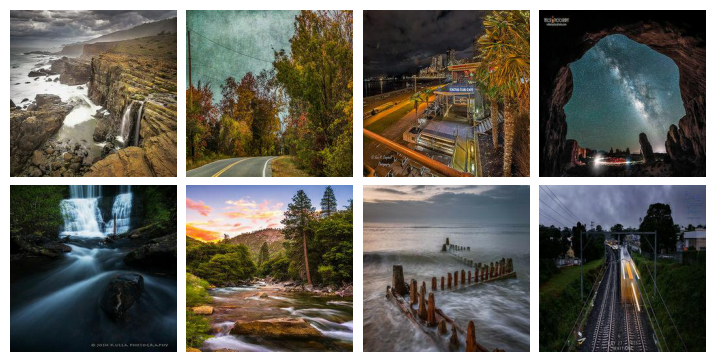

In [9]:
print('Example of regular photos.')
plot_examples('photo')

When looking at some sample images, I will mostly need to trust the dataset creators when it comes to knowing if any of these images would be considered an outlier or would need "cleaning". I will assume that all Monet images are real and all photos are normal non-Monet images.

Something interesting to note, it looks like the regular photos could contain watermarks that may couse some confusion in the model. Something else I noticed is that all Monet images, wouldn't contain modern looking scenery such as the paved road that can be seen in the regular photos.

---

## Model Architecture and Tuning

The architecture used for model will be a UNET based CycleGAN. The CycleGAN model will be based off the provided resource of the competition here: [CycleGAN Notebook](https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial/notebook). I intend to make modifications to the CycleGAN model to see if I am able to create a model that performs better.  

A CycleGAN is a type of deep learning model used to transform images from one domain to another without requiring paired examples. The model consists of two generator networks and two discriminator networks. It learns to map images from one domain to another and back again, aiming to preserve key features of the original image while altering its appearance. The cycle-consistency loss ensures that the reconstructed image is close to the original input. The optionally included identity loss encourages the model to maintain the original content of an input when it should remain unchanged during the transformation process.

Due to how the Kaggle competition is set up, all model building and submission will be done using Kaggle notebooks. I will create 1 notebook for each configuration change to the model. I will then read the result into this final report notebook. The link to the individual notebooks can be found here [Individual Model Notebook Link](https://github.com/rpforrest1/Monet_CycleGAN_Project/tree/main/trained_nbs). Since there are limitations to how much Kaggle compute can be used, I will not be able to try out many configurations.

Below are the model definitions for this round of testing:
- model-1: BCE Loss, Random rotate and zoom is True, and epoch of 20
- model-2: MSE Loss, Random rotate and zoom is True, and epoch of 20
- model-3: BCE Loss, Random rotate and zoom is False, and epoch of 20
- model-4: MSE Loss, Random rotate and zoom is False, and epoch of 20
- model-5: Same as model-1 except epoch is set to 40
- model-6: Same as model-2 except epoch is set to 40
- model-7: Same as model-3 except epoch is set to 40
- model-8: Same as model-4 except epoch is set to 40

Below are the Kaggle scores for the models:  
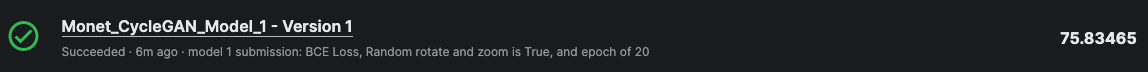
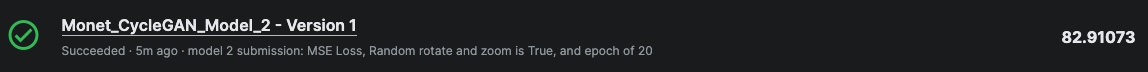
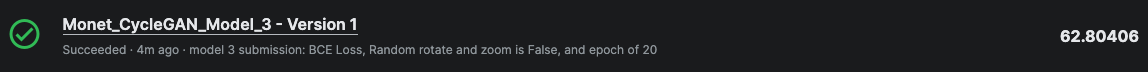
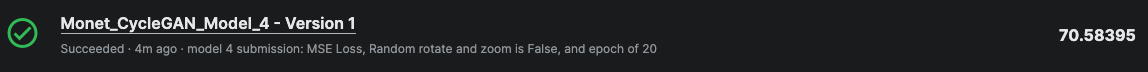
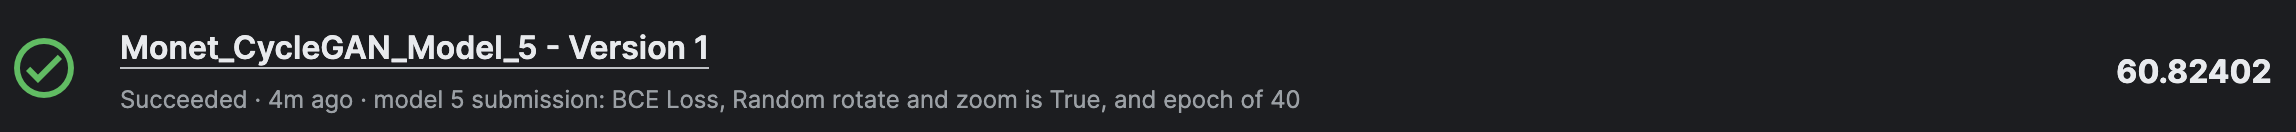
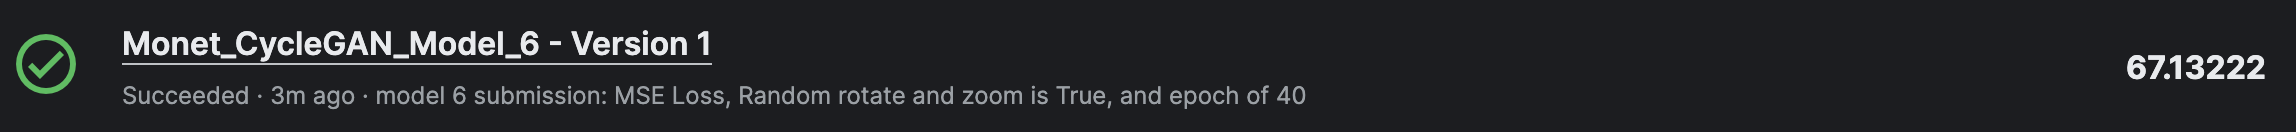
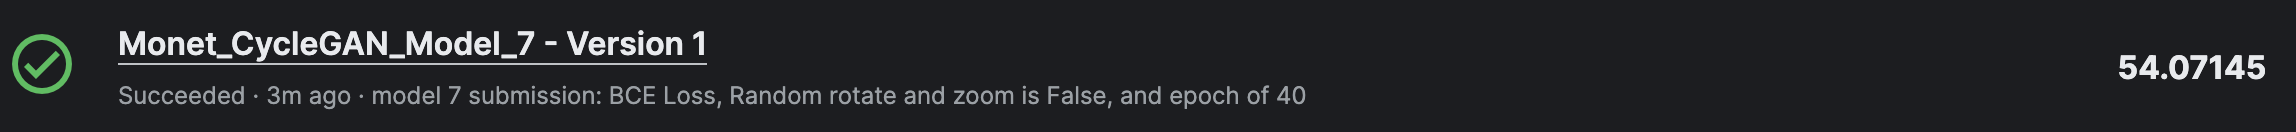
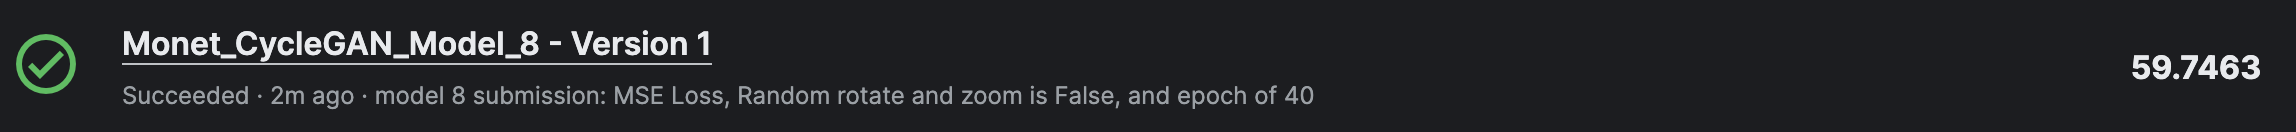

In [10]:
# Create DataFrame of the results
round_1_results = pd.DataFrame.from_records([
    ('model_1', 'bce', True, 20, 75.83465),
    ('model_2', 'mse', True, 20, 82.91073),
    ('model_3', 'bce', False, 20, 62.80406),
    ('model_4', 'mse', False, 20, 70.58395),
    ('model_5', 'bce', True, 40, 60.82402),
    ('model_6', 'mse', True, 40, 67.13222),
    ('model_7', 'bce', False, 40, 54.07145),
    ('model_8', 'mse', False, 40, 59.7463),
], columns=['model', 'loss', 'rotate_&_zoom', 'epoch', 'score'])

display(round_1_results.sort_values('score'))

model loss  rotate_&_zoom  epoch     score
6  model_7  bce          False     40  54.07145
7  model_8  mse          False     40  59.74630
4  model_5  bce           True     40  60.82402
2  model_3  bce          False     20  62.80406
5  model_6  mse           True     40  67.13222
3  model_4  mse          False     20  70.58395
0  model_1  bce           True     20  75.83465
1  model_2  mse           True     20  82.91073

From the Kaggle score results, model-7 turned out to be the best. Model-7 used BCE loss, did not use random rotation a zoom for the images, and had an epoch of 40.  
Next are some plots of the results so that the differences in configurations can be reviewed. After looking through the plots, I will provide some takeaways and determine what the next steps are.

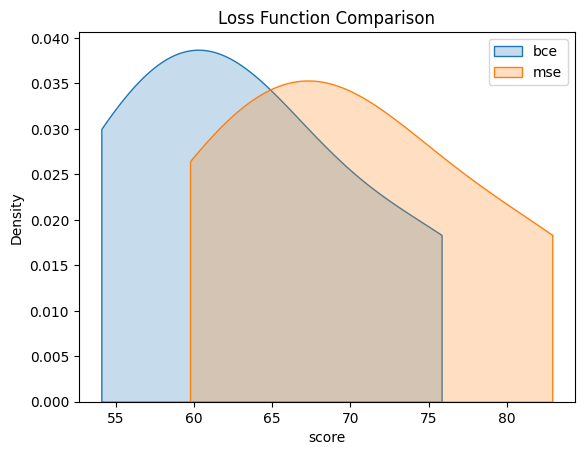

In [11]:
plt.title('Loss Function Comparison')
for group, group_df in round_1_results.groupby('loss'):
    sns.kdeplot(group_df['score'], label=group, cut=0, fill=True)
_ = plt.legend()

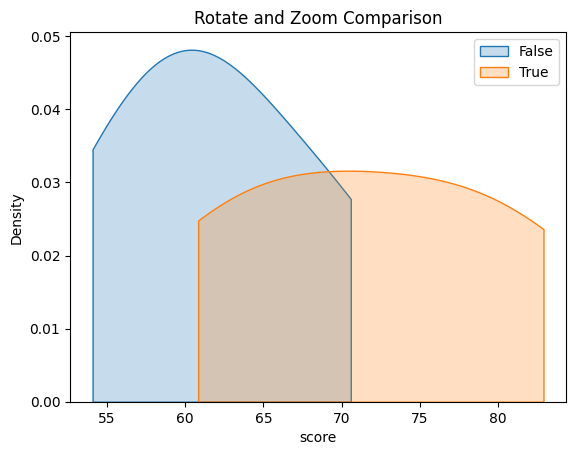

In [12]:
plt.title('Rotate and Zoom Comparison')
for group, group_df in round_1_results.groupby('rotate_&_zoom'):
    sns.kdeplot(group_df['score'], label=group, cut=0, fill=True)
_ = plt.legend()

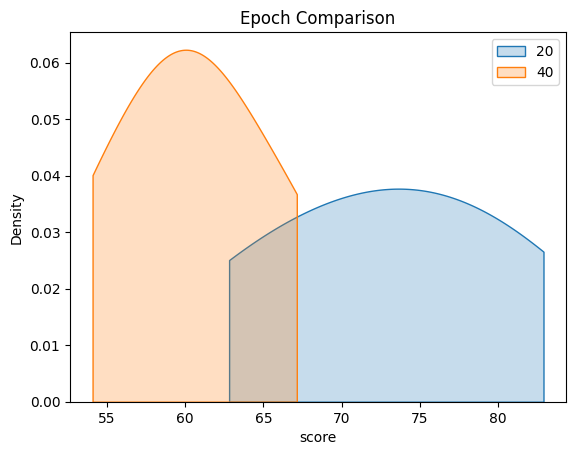

In [13]:
plt.title('Epoch Comparison')
for group, group_df in round_1_results.groupby('epoch'):
    sns.kdeplot(group_df['score'], label=group, cut=0, fill=True)
_ = plt.legend()

Based on the score comparison results, the best model would have use BCE loss, no random rotate and zoom applied to the images, and a high number of epochs. So the best model so far would be model-7 since it meets all those criteria.  
Some takeaways are:  
- I am not entirely sure why BCE performs better that MSE, but the difference is at least small enough that either could be likely be used.
- When looking at how randomly zooming and rotating affects the image, I believe its too much distortion that the style is slightly lost.
- The main factor that affected the score was the number of epochs. The epochs need to be large enough that the generators and discriminators have enough iterations to learn.

---

## Further Tuning and Final Results

Now that the first batch of models have been analyzed, next will be to do more refinement to see if a better model can be created. This time, I will alter only the epochs since that was the variable that mattered most to the score. The model creation can be found in this folder [here](https://github.com/rpforrest1/Monet_CycleGAN_Project/tree/main/trained_nbs). I will fit 4 more models in order so see if epochs continue to be significant in determining the score.  
- model-9: BCE Loss, Random rotate and zoom is False, and epoch of 60
- model-10: Same as model-9 except epoch is set to 80
- model-11: Same as model-9 except epoch is set to 100
- model-12: Same as model-9 except epoch is set to 120

Below are the Kaggle scores for the models:
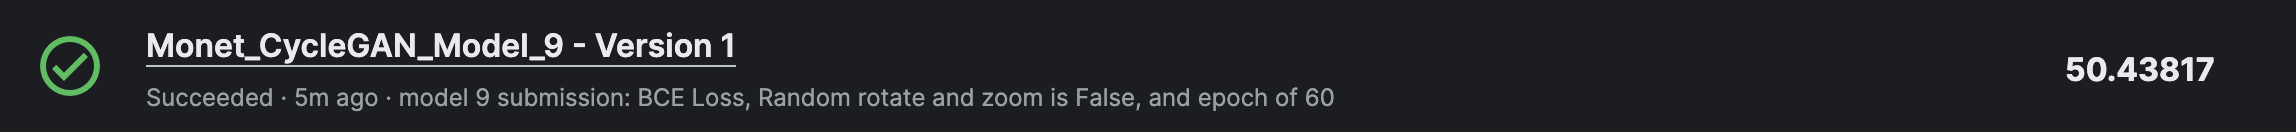
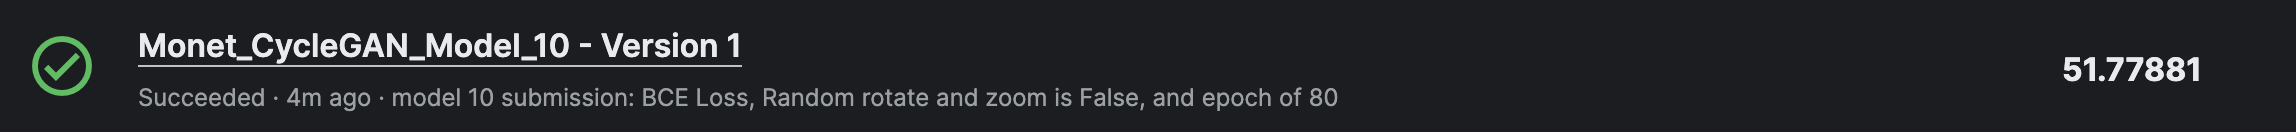
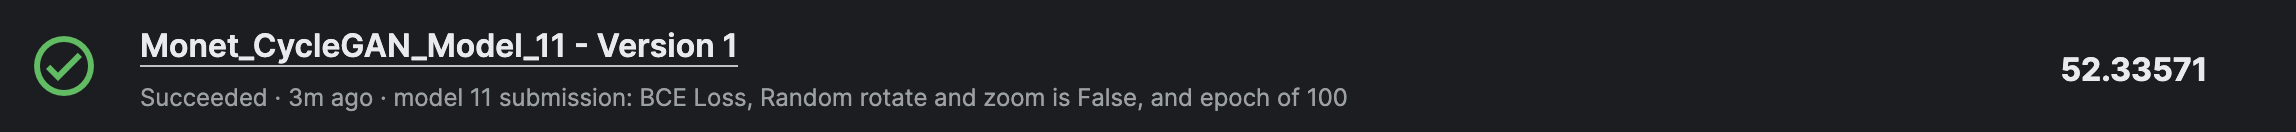
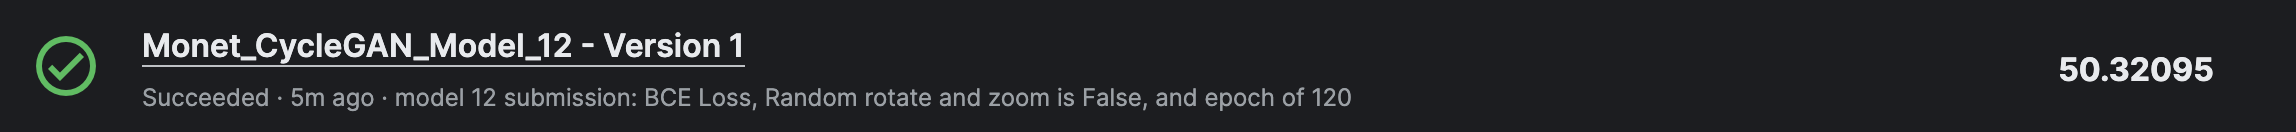

In [14]:
# Create DataFrame of the results
round_2_results = pd.DataFrame.from_records([
    ('model_9', 'bce', False, 60, 50.43817),
    ('model_10', 'bce', False, 80, 51.77881),
    ('model_11', 'bce', False, 100, 52.33571),
    ('model_12', 'bce', False, 120, 50.32095),
], columns=['model', 'loss', 'rotate_&_zoom', 'epoch', 'score'])

display(round_2_results.sort_values('score'))

model loss  rotate_&_zoom  epoch     score
3  model_12  bce          False    120  50.32095
0   model_9  bce          False     60  50.43817
1  model_10  bce          False     80  51.77881
2  model_11  bce          False    100  52.33571

From the Kaggle score results, model-12 turned out to be the best, but model-9 has a very close score. I would overall say that model-9 is the best since it acheives a good score with less epochs. Model-9 used BCE loss, did not use random rotation a zoom for the images, and had an epoch of 60.


In [15]:
# Get extra results from round 1 to display with round 2 results.
# Only epoch will change between models.
trimmed_round_1_results = round_1_results[(round_1_results['loss'] == 'bce') & (round_1_results['rotate_&_zoom'] == False)]

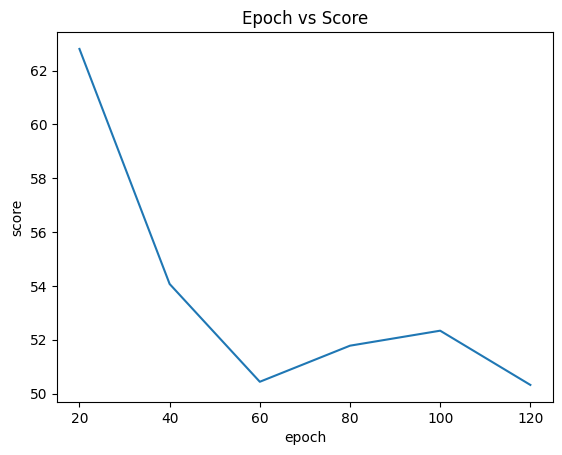

In [16]:
plt.title('Epoch vs Score')
sns.lineplot(pd.concat([round_2_results, trimmed_round_1_results]), x='epoch', y='score')
plt.show()

Here are some results for transforming the regular images into Monet-esque images.
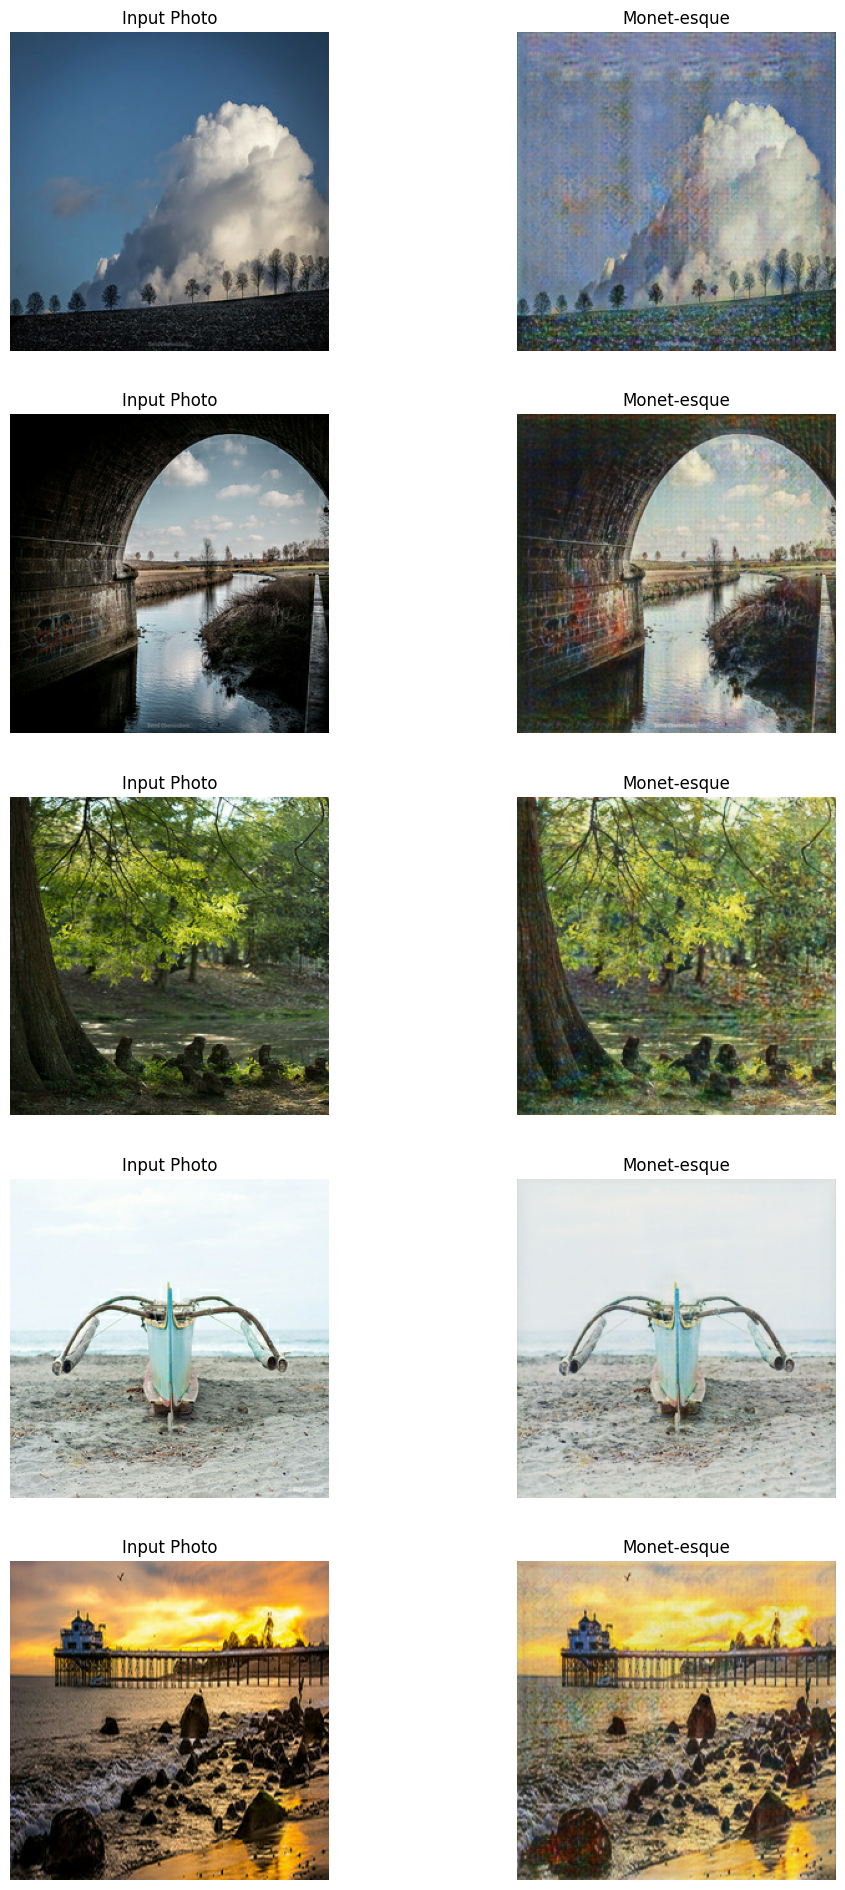

Overall I believe the images look ok. There appears to be some issue with transforming a dark blue sky (like in the first image). Its interesting that it was able to remove the vignette from the first image, which doesn't appear in paintings since vignettes can be caused by the camera itself.

---

## Conclusion

Overall the UNET CycleGAN architecture worked out well and achieved a good score. It looks like the most important parameter for determining model quality was epoch. This makes sense in that the model's generators and discriminators are slowly getting better as time passes and enough iterations need to occur until believable results are produced. Using binary cross entropy as the loss function instead of mean quared error ultimately allowed for less epochs required. It would be interesting to see other architectures applied to this task such as UNIT (Unsupervised Image-to-Image Translation Networks), MUNIT (Multimodal Unsupervised Image-to-Image Translation) or DRIT (Diverse Image-to-Image Translation via Disentangled Representations). There appears to be diminishing returns as epoch increases, so I believe some architecture changes or more data would be needed in order to improve model results.

---

## References

- https://www.coursera.org/learn/apply-generative-adversarial-networks-gans/home/week/2
- https://www.coursera.org/learn/apply-generative-adversarial-networks-gans/home/week/3
- https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial/notebook

---